# 欠拟合和过拟合

### 训练误差和泛化误差

机器学习模型在训练数据集上表现出的误差叫做训练误差，在任意一个测试数据样本上表现出的误差的期望值叫做泛化误差。

统计学习理论的一个假设是：训练数据集和测试数据集里的每一个数据样本都是从同一个概率分布中相互独立地生成出的（独立同分布假设）。

一个重要结论是：训练误差的降低不一定意味着泛化误差的降低。机器学习既需要降低训练误差，又需要降低泛化误差。

### 欠拟合和过拟合

* 欠拟合：机器学习模型无法得到较低训练误差。
* 过拟合：机器学习模型的训练误差远小于其在测试数据集上的误差。

### 模型的选择

模型拟合能力和误差之间的关系如下图：

![](error_model_complexity.png)

### 训练数据集的大小

一般来说，如果训练数据集过小，特别是比模型参数数量更小时，过拟合更容易发生。除此之外，泛化误差不会随训练数据集里样本数量增加而增大。

![](model_vs_data.png)

### 多项式拟合

给定一个**标量**数据点集合`x`和对应的标量目标值`y`，多项式拟合的目标是找一个K阶多项式，其由向量`w`和位移`b`组成，来最好地近似每个样本`x`和`y`。用数学符号来表示就是我们将学`w`和`b`来预测

$$\hat{y} = b + \sum_{k=1}^K x^k w_k$$

并以平方误差为损失函数，一阶多项式拟合又叫线性拟合。

## 创建数据集

使用二阶多项式来生成每一个数据样本，$y=1.2x−3.4x^2+5.6x^3+5.0+noise$，噪音服从均值0和标准差为0.1的正态分布。

In [1]:
# 导入mxnet
import mxnet as mx

# 设置随机种子
mx.random.seed(2)

from mxnet import gluon
from mxnet import ndarray as nd
from mxnet import autograd

In [2]:
# 训练数据数量
num_train = 100
# 测试数据数量
num_test = 100
# 多项式权重
true_w = [1.2, -3.4, 5.6]
# 多项式偏置
true_b = 5.0

In [5]:
# 生成随机数据x
x = nd.random.normal(shape=(num_train + num_test, 1))
# 计算x的多项式值
X = nd.concat(x, nd.power(x, 2), nd.power(x, 3))
# 计算y
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_w[2] * X[:, 2] + true_b
# 查看数据
('x:', x[:5], 'X:', X[:5], 'y:', y[:5])

(200L,)


## 定义训练和测试步骤

In [6]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

# 定义训练过程
def train(X_train, X_test, y_train, y_test):
    # 定义线性回归模型
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    # 权重初始化
    net.initialize()
    # 学习率
    learning_rate = 0.01
    # 迭代周期
    epochs = 100
    # 训练的批数据大小
    batch_size = min(10, y_train.shape[0])
    # 创建训练数据集
    dataset_train = gluon.data.ArrayDataset(X_train, y_train)
    # 读取数据
    data_iter_train = gluon.data.DataLoader(dataset_train, batch_size, shuffle=True)
    # 训练方法SGD
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})
    # 定义损失函数
    square_loss = gluon.loss.L2Loss()
    # 训练损失
    train_loss = []
    # 测试损失
    test_loss = []
    # 进行训练
    for e in range(epochs):
        for data, label in data_iter_train:
            with autograd.record():
                # 进行预测
                output = net(data)
                # 计算预测值与实际值之间的损失
                loss = square_loss(output, label)
            # 损失进行反向传播
            loss.backward()
            # 更新权重
            trainer.step(batch_size)
        # 保存训练损失
        train_loss.append(square_loss(net(X_train), y_train).mean().asscalar())
        # 保存测试损失
        test_loss.append(square_loss(net(X_test), y_test).mean().asscalar())
    # 绘制损失
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train','test'])
    plt.show()
    return ('learned weight', net[0].weight.data(), 'learned bias', net[0].bias.data())

## 三阶多项式拟合（正常）

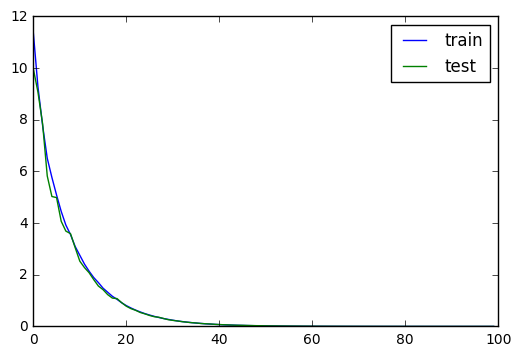

('learned weight', 
 [[ 1.22117233 -3.39606118  5.59531116]]
 <NDArray 1x3 @cpu(0)>, 'learned bias', 
 [ 4.98550272]
 <NDArray 1 @cpu(0)>)

In [7]:
train(X[:num_train, :], X[num_train:, :], y[:num_train], y[num_train:])

## 线性拟合（欠拟合）

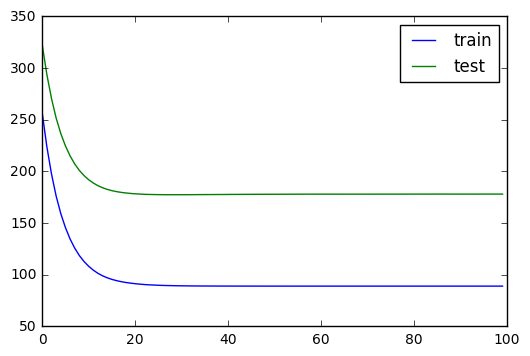

('learned weight', 
 [[ 19.74101448]]
 <NDArray 1x1 @cpu(0)>, 'learned bias', 
 [-0.23861444]
 <NDArray 1 @cpu(0)>)

In [9]:
train(x[:num_train, :], x[num_train:, :], y[:num_train], y[num_train:])

## 训练量不足（过拟合）

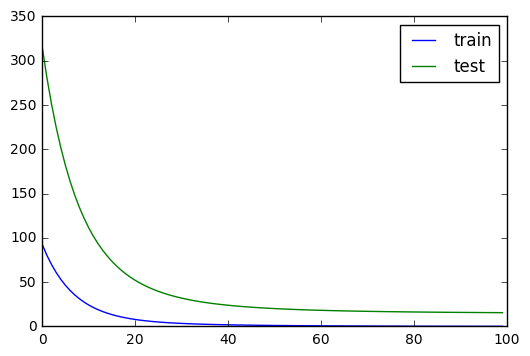

('learned weight', 
 [[ 3.10832024 -0.740421    4.85165691]]
 <NDArray 1x3 @cpu(0)>, 'learned bias', 
 [ 0.29450524]
 <NDArray 1 @cpu(0)>)

In [10]:
train(X[0:2, :], X[num_train:, :], y[0:2], y[num_train:])

## 结论

* 训练误差的降低并不一定意味着泛化误差的降低。
* 欠拟合和过拟合都是需要尽量避免的。我们要注意模型的选择和训练量的大小。